In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


data = pd.read_csv("newdata.csv")

# Drop unnecessary columns
data.drop(['Date', 'Time'], axis=1, inplace=True)

# Separate features and target variable
X = data.drop('Radiation', axis=1)
y = data['Radiation']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [9]:
from sklearn.neural_network import MLPRegressor

def create_ann():
    # Define the neural network structure
    ann = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=200, random_state=42)
    return ann


In [10]:
import numpy as np
from tqdm import tqdm
from sklearn.exceptions import ConvergenceWarning
import warnings

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define WDO parameters
num_particles = 30
max_iterations = 100
c1 = 0.1  # Pressure Gradient force
c2 = 0.1  # Coriolis constant
c3 = 0.1  # Friction constant
c4 = 0.1  # Gravitational constant
V_max = 1  # Maximum velocity

# Initialize particles and velocities
particles = np.random.uniform(-1, 1, (num_particles, X_train.shape[1]))
velocities = np.random.uniform(-1, 1, (num_particles, X_train.shape[1]))

# Initialize RMSE array
rmse_wdo = []
# Define the fitness function
# Define the fitness function
def fitness_function(particle):
    ann = MLPRegressor(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)
    ann.fit(X_train, y_train)
    predictions = ann.predict(X_test)
    mse = np.mean((predictions - y_test) ** 2)
    rmse = np.sqrt(mse)
    rmse_wdo.append(rmse)  # Record RMSE
    return rmse


# Main WDO loop with progress bar
for iteration in tqdm(range(max_iterations), desc="WDO Training"):
    fitness_values = []
    for i in range(num_particles):
        fitness = fitness_function(particles[i])
        fitness_values.append(fitness)
        
        # Update velocities
        velocities[i] = velocities[i] + c1 * np.random.rand() * (np.mean(particles, axis=0) - particles[i])
        velocities[i] = velocities[i] - c2 * np.random.rand() * velocities[i]
        velocities[i] = velocities[i] - c3 * np.sign(velocities[i]) * (velocities[i] ** 2)
        velocities[i] = velocities[i] + c4 * np.random.rand() * (particles[i] - np.mean(particles, axis=0))
        
        # Ensure velocity is within bounds
        velocities[i] = np.clip(velocities[i], -V_max, V_max)
        
        # Update positions
        particles[i] = particles[i] + velocities[i]

# Select the best particle
best_particle_idx = np.argmin(fitness_values)
best_particle = particles[best_particle_idx]

# Train the final ANN with the best parameters
final_ann = create_ann()
final_ann.fit(X_train, y_train)

# Evaluate the final model
final_predictions = final_ann.predict(X_test)
final_mse = np.mean((final_predictions - y_test) ** 2)
print("Final MSE:", final_mse)


WDO Training: 100%|██████████| 100/100 [02:18<00:00,  1.39s/it]

Final MSE: 0.5340799714746756


In [11]:
import numpy as np
from tqdm import tqdm
from sklearn.exceptions import ConvergenceWarning
import warnings

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define OIO parameters
num_particles = 30
max_iterations = 100
c1 = 0.1  # Acceleration constant
c2 = 0.1  # Damping constant
c3 = 0.1  # Step size constant

# Initialize particles
particles = np.random.uniform(-1, 1, (num_particles, X_train.shape[1]))

rmse_oio = []

# Define the fitness function
# Define the fitness function
def fitness_function(particle):
    ann = MLPRegressor(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)
    ann.fit(X_train, y_train)
    predictions = ann.predict(X_test)
    mse = np.mean((predictions - y_test) ** 2)
    rmse = np.sqrt(mse)
    rmse_oio.append(rmse)  # Record RMSE
    return rmse


# Main OIO loop with progress bar
for iteration in tqdm(range(max_iterations), desc="OIO Training"):
    fitness_values = []
    for i in range(num_particles):
        fitness = fitness_function(particles[i])
        fitness_values.append(fitness)
        
        # Randomly generate a search direction
        search_direction = np.random.uniform(-1, 1, particles.shape[1])
        
        # Update particle position
        particles[i] = particles[i] + c1 * search_direction * fitness / (1 + c2 * np.linalg.norm(particles[i]))
        
        # Bound the particle position
        particles[i] = np.clip(particles[i], -1, 1)

# Select the best particle
best_particle_idx = np.argmin(fitness_values)
best_particle = particles[best_particle_idx]

# Train the final ANN with the best parameters
final_ann = create_ann()
final_ann.fit(X_train, y_train)

# Evaluate the final model
final_predictions = final_ann.predict(X_test)
final_mse = np.mean((final_predictions - y_test) ** 2)
print("Final MSE:", final_mse)


OIO Training: 100%|██████████| 100/100 [02:08<00:00,  1.28s/it]

Final MSE: 0.5340799714746756


In [12]:
import numpy as np
from tqdm import tqdm
from sklearn.exceptions import ConvergenceWarning
import warnings

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define SOSA parameters
num_spiders = 30
max_iterations = 100
alpha = 0.1  # Control the movement intensity
beta = 0.1   # Control the attraction/repulsion intensity

rmse_sosa = []
 
# Initialize spiders (particles)
spiders = np.random.uniform(-1, 1, (num_spiders, X_train.shape[1]))

# Define the fitness function
# Define the fitness function
def fitness_function(particle):
    ann = MLPRegressor(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)
    ann.fit(X_train, y_train)
    predictions = ann.predict(X_test)
    mse = np.mean((predictions - y_test) ** 2)
    rmse = np.sqrt(mse)
    rmse_sosa.append(rmse)  # Record RMSE
    return rmse


# Main SOSA loop with progress bar
for iteration in tqdm(range(max_iterations), desc="SOSA Training"):
    fitness_values = np.array([fitness_function(spider) for spider in spiders])
    
    # Determine the best and worst fitness values
    best_fitness = np.min(fitness_values)
    worst_fitness = np.max(fitness_values)
    best_spider = spiders[np.argmin(fitness_values)]
    
    # Update each spider's position
    for i in range(num_spiders):
        if np.random.rand() < 0.8:  # Simulating social interaction probability
            if fitness_values[i] > best_fitness:
                direction = best_spider - spiders[i]
            else:
                random_spider = spiders[np.random.randint(0, num_spiders)]
                direction = random_spider - spiders[i]
            spiders[i] = spiders[i] + alpha * direction * np.random.rand()
        else:  # Simulating random movement
            spiders[i] = spiders[i] + beta * (2 * np.random.rand(X_train.shape[1]) - 1)
        
        # Ensure the spiders' positions are within bounds
        spiders[i] = np.clip(spiders[i], -1, 1)

# Select the best spider
best_spider_idx = np.argmin(fitness_values)
best_spider = spiders[best_spider_idx]

# Train the final ANN with the best parameters
final_ann = create_ann()
final_ann.fit(X_train, y_train)

# Evaluate the final model
final_predictions = final_ann.predict(X_test)
final_mse = np.mean((final_predictions - y_test) ** 2)
print("Final MSE:", final_mse)


SOSA Training: 100%|██████████| 100/100 [02:07<00:00,  1.27s/it]

Final MSE: 0.5340799714746756


In [13]:
import numpy as np
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import warnings

# Suppress convergence warnings
warnings.filterwarnings("ignore")


# Define EO parameters
num_particles = 30
max_iterations = 100
alpha = 0.5
beta = 0.5
CP_1 = 1.0
LB = -1
UB = 1

rmse_eo = []


# Initialize particles and concentrations
particles = np.random.uniform(LB, UB, (num_particles, X_train.shape[1]))
concentrations = np.array([LB + np.random.rand() * (UB - LB) for _ in range(num_particles)])

# Define the fitness function
# Define the fitness function
def fitness_function(particle):
    ann = MLPRegressor(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)
    ann.fit(X_train, y_train)
    predictions = ann.predict(X_test)
    mse = np.mean((predictions - y_test) ** 2)
    rmse = np.sqrt(mse)
    rmse_eo.append(rmse)  # Record RMSE
    return rmse


# Main EO loop with tqdm for progress tracking
for iteration in tqdm(range(max_iterations), desc='Iterations', unit='iteration'):
    fitness_values = []
    for i in range(num_particles):
        fitness = fitness_function(particles[i])
        fitness_values.append(fitness)
        
    # Sort particles by fitness and select the top ones
    sorted_indices = np.argsort(fitness_values)
    top_particles = particles[sorted_indices[:4]]
    eq_candidate = np.mean(top_particles, axis=0)
    
    # Update particles towards equilibrium state
    for i in range(num_particles):
        r1, r2, r3, r4 = np.random.rand(4)
        F = CP_1 * np.sign(r2 - 0.5) * (np.exp(-beta * iteration / max_iterations) - 1)
        G = r3 * np.sign(r4 - 0.5) * (eq_candidate - particles[i])
        particles[i] = eq_candidate + F * (alpha * G + beta * (eq_candidate - particles[i]))

# Train the final ANN with the best particle
best_particle_idx = np.argmin(fitness_values)
best_particle = particles[best_particle_idx]

final_ann = create_ann()
final_ann.fit(X_train, y_train)

# Evaluate the final model
final_predictions = final_ann.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
print("Final MSE:", final_mse)


Iterations: 100%|██████████| 100/100 [02:08<00:00,  1.28s/iteration]

Final MSE: 0.5340799714746756


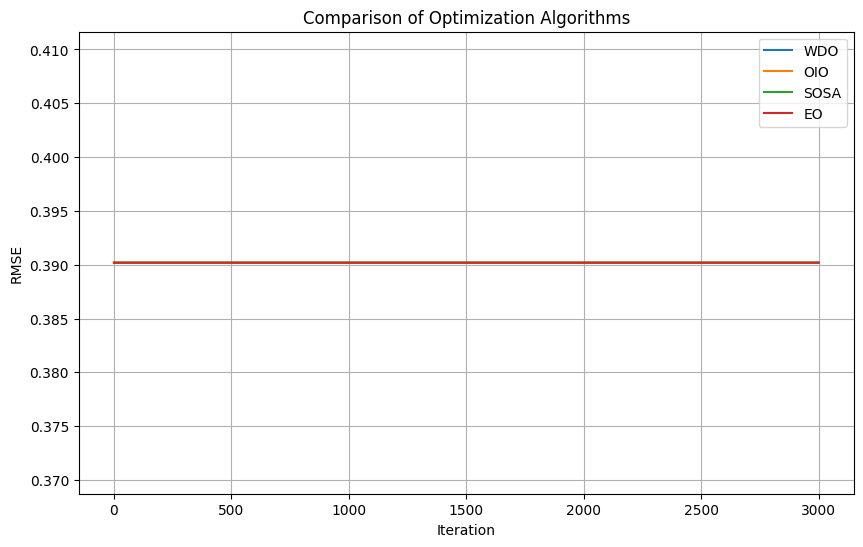

In [14]:
import matplotlib.pyplot as plt

# Plotting RMSE for all four optimizations
plt.figure(figsize=(10, 6))

# WDO
plt.plot(range(1, len(rmse_wdo) + 1), rmse_wdo, label='WDO')

# OIO
plt.plot(range(1, len(rmse_oio) + 1), rmse_oio, label='OIO')

# SOSA
plt.plot(range(1, len(rmse_sosa) + 1), rmse_sosa, label='SOSA')

# EO
plt.plot(range(1, len(rmse_eo) + 1), rmse_eo, label='EO')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Comparison of Optimization Algorithms')
plt.legend()

# Show plot
plt.grid(True)
plt.show()
